In [1]:
# General imports 
import os 
import re
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats 
from skimage import measure
import matplotlib.pyplot as plt
import json
import zarr

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

# set paths
sys.path.insert(0, '/code/src')
data_dir = '/data'

# package imports
from bci.loaders import load
from bci.thresholds.thresholds import align_thresholds
from bci.processing import processing
from bci.trials.align import indep_roll
from scipy import ndimage
from sklearn.model_selection import cross_validate

In [2]:
df=load.load_filtered_metadata()
mouse = df[df['subject_id']==754303].sort_values(by='session_date')
mouse

,project_name,session_type,_id,name,subject_id,genotype,virus,date_of_birth,sex,modality,session_date,age,session_time,targeted_structure,ophys_fov,session_number
14,Brain Computer Interface,BCI single neuron stim,3aac9323-c4f9-4172-9f1a-6c12cb3bc44e,single-plane-ophys_754303_2025-01-22_18-22-38_...,754303,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-07-17,Male,Planar optical physiology,2025-01-22,189,16:59:35.618000,Primary Motor Cortex,FOV_01,2.0
16,Brain Computer Interface,BCI single neuron stim,aaf560f4-bb1f-449a-aaf9-5054432b47ae,single-plane-ophys_754303_2025-01-23_19-48-32_...,754303,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-07-17,Male,Planar optical physiology,2025-01-23,190,18:36:30.521000,Primary Motor Cortex,FOV_01,3.0
15,Brain Computer Interface,BCI single neuron stim,7efb85e4-0dba-43fe-a0fd-2b8348e05b69,single-plane-ophys_754303_2025-01-27_20-01-31_...,754303,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-07-17,Male,Planar optical physiology,2025-01-27,194,18:46:54.109999,Primary Motor Cortex,FOV_01,5.0
17,Brain Computer Interface,BCI single neuron stim,5fa54429-8887-48b7-a3db-5526d7fa3fe5,single-plane-ophys_754303_2025-01-29_16-07-41_...,754303,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-07-17,Male,Planar optical physiology,2025-01-29,196,16:07:41.655000,Primary Motor Cortex,FOV_01,6.0
18,Brain Computer Interface,BCI single neuron stim,737557e6-4bb3-423f-8fae-a2a63ee600e7,single-plane-ophys_754303_2025-01-31_15-13-50_...,754303,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-07-17,Male,Planar optical physiology,2025-01-31,198,15:13:50.595999,Primary Motor Cortex,FOV_01,8.0
19,Brain Computer Interface,BCI single neuron stim,02859cbf-4099-4508-a2d1-6bad82ffcebb,single-plane-ophys_754303_2025-02-03_15-24-22_...,754303,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-07-17,Male,Planar optical physiology,2025-02-03,201,15:24:22.163000,Primary Motor Cortex,FOV_02,9.0


In [5]:
color=['#004C52','#017577','#02A196','#07B89F','#0BC7A2','#12E4A1']

BCI data directory: /data/brain-computer-interface

Session directory: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-22_18-22-38_processed_2025-08-06_18-52-36

NWB file: single-plane-ophys_754303_2025-01-22_18-22-38_behavior_nwb
NWB path: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-22_18-22-38_processed_2025-08-06_18-52-36/single-plane-ophys_754303_2025-01-22_18-22-38_behavior_nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


All threshold files for mouse 754303: ['single-plane-ophys_754303_2025-01-27', 'single-plane-ophys_754303_2025-01-23', 'single-plane-ophys_754303_2025-01-29', 'single-plane-ophys_754303_2025-01-31', 'single-plane-ophys_754303_2025-02-03']

BCI data directory: /data/brain-computer-interface

Session directory: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-23_19-48-32_processed_2025-08-08_15-29-29

NWB file: single-plane-ophys_754303_2025-01-23_19-48-32_behavior_nwb
NWB path: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-23_19-48-32_processed_2025-08-08_15-29-29/single-plane-ophys_754303_2025-01-23_19-48-32_behavior_nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


All threshold files for mouse 754303: ['single-plane-ophys_754303_2025-01-27', 'single-plane-ophys_754303_2025-01-23', 'single-plane-ophys_754303_2025-01-29', 'single-plane-ophys_754303_2025-01-31', 'single-plane-ophys_754303_2025-02-03']

Found threshold file at: /data/bci-thresholds/single-plane-ophys_754303_2025-01-23
total difference in dataframes: 4
BCI data directory: /data/brain-computer-interface

Session directory: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-27_20-01-31_processed_2025-08-07_06-00-10

NWB file: single-plane-ophys_754303_2025-01-27_20-01-31_behavior_nwb
NWB path: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-27_20-01-31_processed_2025-08-07_06-00-10/single-plane-ophys_754303_2025-01-27_20-01-31_behavior_nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


All threshold files for mouse 754303: ['single-plane-ophys_754303_2025-01-27', 'single-plane-ophys_754303_2025-01-23', 'single-plane-ophys_754303_2025-01-29', 'single-plane-ophys_754303_2025-01-31', 'single-plane-ophys_754303_2025-02-03']

Found threshold file at: /data/bci-thresholds/single-plane-ophys_754303_2025-01-27
total difference in dataframes: 5
BCI data directory: /data/brain-computer-interface

Session directory: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-29_16-07-41_processed_2025-08-04_04-39-41

NWB file: single-plane-ophys_754303_2025-01-29_16-07-41_behavior_nwb
NWB path: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-29_16-07-41_processed_2025-08-04_04-39-41/single-plane-ophys_754303_2025-01-29_16-07-41_behavior_nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


All threshold files for mouse 754303: ['single-plane-ophys_754303_2025-01-27', 'single-plane-ophys_754303_2025-01-23', 'single-plane-ophys_754303_2025-01-29', 'single-plane-ophys_754303_2025-01-31', 'single-plane-ophys_754303_2025-02-03']

Found threshold file at: /data/bci-thresholds/single-plane-ophys_754303_2025-01-29
total difference in dataframes: 14
BCI data directory: /data/brain-computer-interface

Session directory: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-31_15-13-50_processed_2025-08-05_20-00-52

NWB file: single-plane-ophys_754303_2025-01-31_15-13-50_behavior_nwb
NWB path: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-31_15-13-50_processed_2025-08-05_20-00-52/single-plane-ophys_754303_2025-01-31_15-13-50_behavior_nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


All threshold files for mouse 754303: ['single-plane-ophys_754303_2025-01-27', 'single-plane-ophys_754303_2025-01-23', 'single-plane-ophys_754303_2025-01-29', 'single-plane-ophys_754303_2025-01-31', 'single-plane-ophys_754303_2025-02-03']

Found threshold file at: /data/bci-thresholds/single-plane-ophys_754303_2025-01-31
total difference in dataframes: 5
BCI data directory: /data/brain-computer-interface

Session directory: /data/brain-computer-interface/single-plane-ophys_754303_2025-02-03_15-24-22_processed_2025-08-04_04-23-48

NWB file: single-plane-ophys_754303_2025-02-03_15-24-22_behavior_nwb
NWB path: /data/brain-computer-interface/single-plane-ophys_754303_2025-02-03_15-24-22_processed_2025-08-04_04-23-48/single-plane-ophys_754303_2025-02-03_15-24-22_behavior_nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


All threshold files for mouse 754303: ['single-plane-ophys_754303_2025-01-27', 'single-plane-ophys_754303_2025-01-23', 'single-plane-ophys_754303_2025-01-29', 'single-plane-ophys_754303_2025-01-31', 'single-plane-ophys_754303_2025-02-03']

Found threshold file at: /data/bci-thresholds/single-plane-ophys_754303_2025-02-03
total difference in dataframes: 24


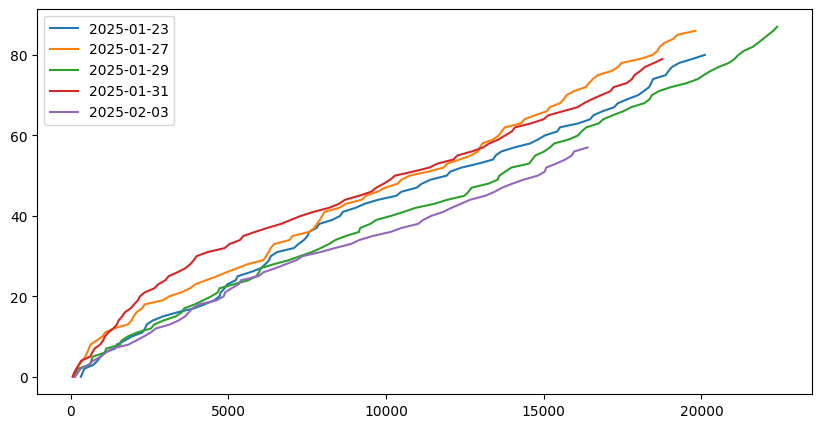

In [7]:
fig,ax=plt.subplots(figsize=(10,5))

for isess,idate in zip(mouse['name'],mouse['session_date']):

    try:
        data = load.load_session_data(isess)
        data['bci_trials'] = processing.correct_bci_trials(data['bci_trials'])
        
        thresh_crossing_frames = np.round(data['bci_trials']['threshold_crossing_times']*data['frame_rate']).astype(int)

        ax.plot(np.cumsum(thresh_crossing_frames.values),np.arange(len(np.cumsum(thresh_crossing_frames.values))),label=idate)
        
    except:
        continue
plt.legend()

In [10]:
isess

[]